In [1]:
# import the necessary libraries

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Import, EDA and Pre-Processing

In [2]:
house_data = pd.read_csv("datasets/kc_house_data.csv")
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
incident_data = pd.read_csv("datasets/KCSO_Incident_Dataset__Historic_to_2019.csv")
incident_data.head()

,case_number,incident_datetime,incident_type,FCR,address_1,city,state,zip,created_at,updated_at,hour_of_day,day_of_week,Incident Block Location
0,C19046940,12/09/2019 09:02:00 AM,Other,503,1 Block AVE & YESLER WAY,SEATTLE,WA,98104,12/12/2019 06:19:00 PM,12/12/2019 08:07:00 PM,9,Monday,NaN
1,C19046039,12/02/2019 06:01:00 PM,Other,162,19700 Block 635TH PL NE,BARING,WA,98224,12/05/2019 05:15:00 PM,12/05/2019 07:06:00 PM,18,Monday,NaN
2,C19026684,07/14/2019 01:29:00 AM,Vehicle Recovery,311,1 Block PL S & DES MOINES MEMORIAL DR S,BURIEN,WA,98168,07/15/2019 05:45:00 AM,07/15/2019 06:09:00 PM,1,Sunday,NaN
3,C19043968,11/16/2019 10:07:00 PM,Traffic,404,RAINIER AVE N & RENTON AVE S,SKYWAY,WA,98178,11/19/2019 04:30:00 PM,11/19/2019 06:16:00 PM,22,Saturday,NaN
4,C19042199,11/04/2019 07:18:00 AM,Property Crime,313,1 Block PL S & DES MOINES MEMORIAL DR S,BURIEN,WA,98168,11/05/2019 04:35:00 PM,11/05/2019 06:26:00 PM,7,Monday,NaN


<AxesSubplot:>

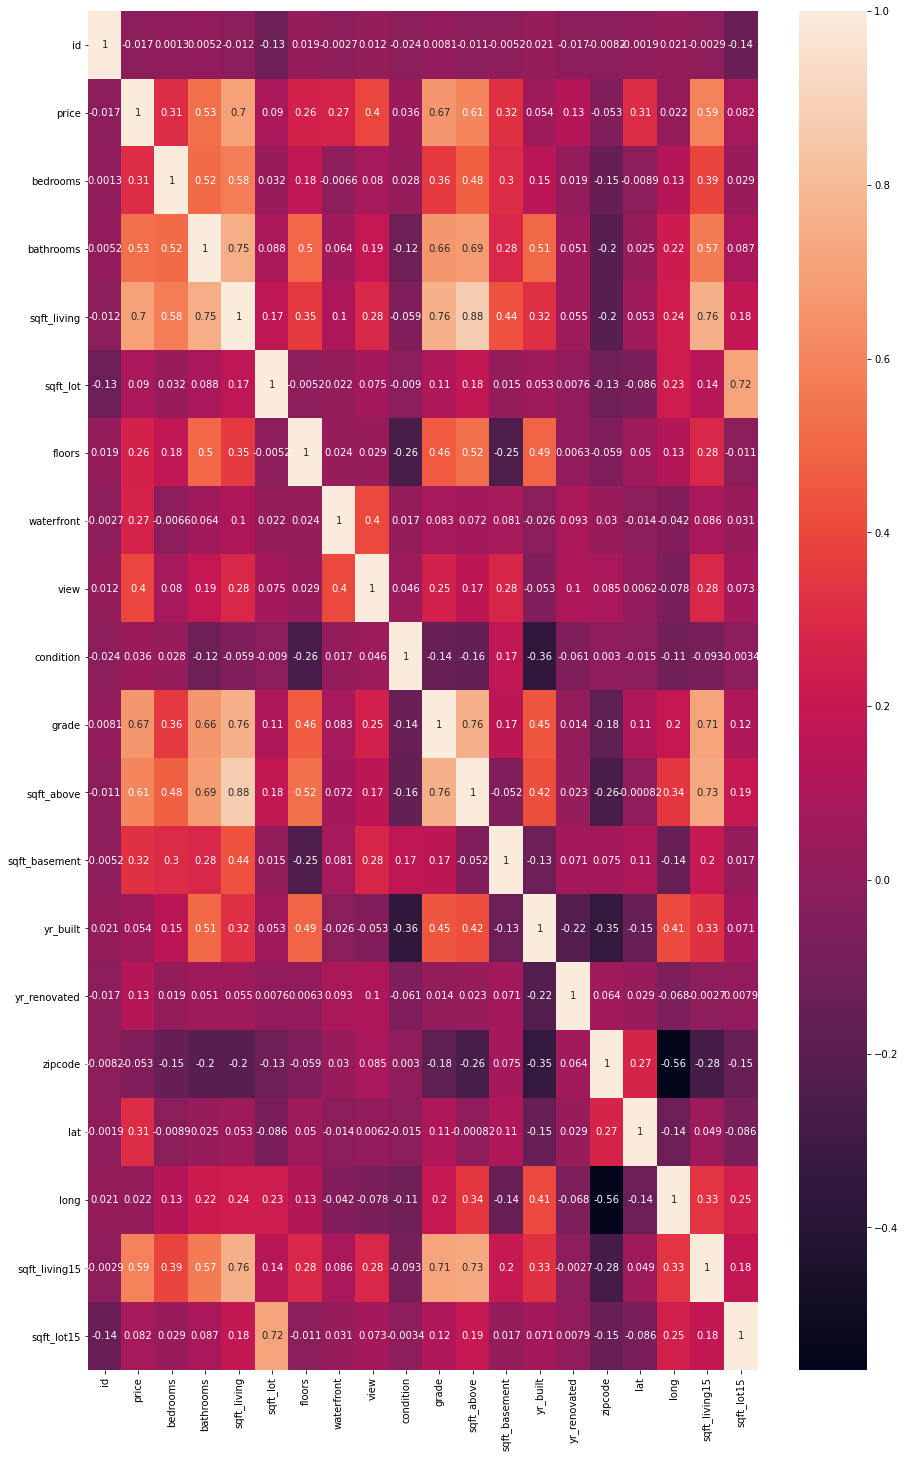

In [4]:
plt.figure(figsize=(15,25))
sns.heatmap(house_data.corr(), annot=True)

In [5]:
# convert those with yr_renovated == 0 to yr_built before dropping the yr_renovated column

house_data["new_yr_renovated"] = [house_data.iloc[i]["yr_renovated"].item() if house_data.iloc[i]["yr_renovated"].item() > 0 else house_data.iloc[i]["yr_built"].item() for i in range(len(house_data))]
house_data.drop(["yr_renovated"], axis=1, inplace=True)
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [6]:
# filter and create a new df for crime incidences that occurred in 2014/15

filtered_incidences = []
for i in range(len(incident_data["incident_datetime"])):
    curr_datetime = incident_data["incident_datetime"][i]
    datetime_split = curr_datetime.split()
    curr_date = datetime.datetime.strptime(datetime_split[0], "%m/%d/%Y")
    if curr_date.year == 2015 or curr_date.year == 2014:
        curr_row = incident_data.iloc[i]
        temp = [curr_date.year, curr_row["zip"]]
        filtered_incidences.append(temp)
filtered_incidences_df = pd.DataFrame(filtered_incidences, columns=["year", "zip"])

In [7]:
# create ref dict for crime numbers per year and zipcode

filtered_dict = {2014:{}, 2015:{}}
for i in range(len(filtered_incidences_df)):
    year, zip_code = filtered_incidences_df.iloc[i]["year"], filtered_incidences_df.iloc[i]["zip"]
    if not math.isnan(float(zip_code)):
        if zip_code not in filtered_dict[year]:
            filtered_dict[year][zip_code] = 1
        else:
            filtered_dict[year][zip_code] += 1
filtered_dict

{2014: {'98058': 2,
  '98024': 2,
  '98146': 1,
  '98065': 1,
  '98001': 3,
  '98038': 1,
  '98105': 1,
  '98022': 1,
  '98037': 1,
  '98023': 1},
 2015: {'98042': 1,
  '98178': 2,
  '98058': 1,
  '98072': 1,
  '98059': 1,
  '98105': 1,
  '98053': 1}}

In [8]:
# create copy of house data for crime numbers to be included later

house_data_with_crime = house_data.copy()
house_data_with_crime.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [9]:
# create column for no. of crimes for house data with crime numbers

crime_numbers = []
for i in range(len(house_data_with_crime)):
    date, zip_code = house_data_with_crime.iloc[i]["date"], str(house_data_with_crime.iloc[i]["zipcode"])
    date_split = date.split("T")
    curr_year = datetime.datetime.strptime(date_split[0], "%Y%m%d").year
    if zip_code not in filtered_dict[curr_year]:
        crime_numbers.append(0)
    else:
        crime_numbers.append(filtered_dict[curr_year][zip_code])
house_data_with_crime["no_of_crimes"] = crime_numbers

# can use below line to check if crime number corresponds to 98058 using ref dict (that was created earlier)
# house_data_with_crime[house_data_with_crime["zipcode"] == 98058]

In [10]:
# drop id and date for both dataframes as they do not provide much value

house_data.drop(["id", "date"], axis=1, inplace=True)
house_data_with_crime.drop(["id", "date"], axis=1, inplace=True)

In [11]:
house_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [12]:
house_data_with_crime.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated,no_of_crimes
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987,0


# Train Test Split

**For house data w/o crime numbers**

In [13]:
X = house_data.iloc[:,1:].values
y = house_data.iloc[:,0].values

# can tune parameters accordingly for experimentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**For house data with crime numbers**

In [14]:
X_2 = house_data_with_crime.iloc[:,1:].values
y_2 = house_data_with_crime.iloc[:,0].values

# can tune parameters accordingly for experimentation
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2)

# Linear Regression

In [15]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regressor.score(X_train, y_train)}")
print(f"R-squared score for test: {regressor.score(X_test, y_test)}")

Evaluation Metrics for LR
MAE: 125880.08400142245
MSE: 41295996592.74809
RMSE: 203214.16435068715
R-squared score for train: 0.6981995012916977
R-squared score for test: 0.7040108094701628


In [16]:
regressor_with_crime = LinearRegression()
regressor_with_crime.fit(X_train_2, y_train_2)
pred_with_crime = regressor_with_crime.predict(X_test_2)
print("Evaluation Metrics for LR (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, pred_with_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, pred_with_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, pred_with_crime))}")
print(f"R-squared score for train: {regressor_with_crime.score(X_train_2, y_train_2)}")
print(f"R-squared score for test: {regressor_with_crime.score(X_test_2, y_test_2)}")

Evaluation Metrics for LR (with crime)
MAE: 124623.17212537189
MSE: 35587590684.24725
RMSE: 188646.73515395715
R-squared score for train: 0.6972440704101286
R-squared score for test: 0.7129077080246402


# Lasso Regression

In [17]:
lasso = Lasso(alpha=0.04)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")

Evaluation Metrics for Lasso
MAE: 125880.05447336964
MSE: 41296003738.06846
RMSE: 203214.18193145
R-squared score for train: 0.6981995012880478
R-squared score for test: 0.7040107582560557


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316101068411682.7, tolerance: 230974158131.58075
  model = cd_fast.enet_coordinate_descent(


In [18]:
lasso_crime = Lasso(alpha=0.04)
lasso_crime.fit(X_train_2, y_train_2)
lasso_pred_crime = lasso_crime.predict(X_test_2)
print("Evaluation Metrics for Lasso (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, lasso_pred_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, lasso_pred_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, lasso_pred_crime))}")
print(f"R-squared score for train: {lasso_crime.score(X_train_2, y_train_2)}")
print(f"R-squared score for test: {lasso_crime.score(X_test_2, y_test_2)}")

Evaluation Metrics for Lasso (with crime)
MAE: 124623.10805629227
MSE: 35587573568.075264
RMSE: 188646.68978827924
R-squared score for train: 0.6972440704065388
R-squared score for test: 0.7129078461042615


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329059222224930.06, tolerance: 237703689206.46677
  model = cd_fast.enet_coordinate_descent(


# XGBoost Regression

In [19]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(X_train, y_train)}")
print(f"R-squared score for test: {xgb.score(X_test, y_test)}")

Evaluation Metrics for XGBoost
MAE: 68068.89390867164
MSE: 14374262712.95773
RMSE: 119892.71334387979
R-squared score for train: 0.9756737108872522
R-squared score for test: 0.8969724250311778


In [20]:
xgb_crime = XGBRegressor()
xgb_crime.fit(X_train_2, y_train_2)
xgb_pred_crime = xgb_crime.predict(X_test_2)
print("Evaluation Metrics for XGBoost (with crime)")
print(f"MAE: {mean_absolute_error(y_test_2, xgb_pred_crime)}")
print(f"MSE: {mean_squared_error(y_test_2, xgb_pred_crime)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, xgb_pred_crime))}")
print(f"R-squared score for train: {xgb_crime.score(X_train_2, y_train_2)}")
print(f"R-squared score for test: {xgb_crime.score(X_test_2, y_test_2)}")

Evaluation Metrics for XGBoost (with crime)
MAE: 68924.50086745316
MSE: 14240081156.217861
RMSE: 119331.81116625131
R-squared score for train: 0.9764370929621681
R-squared score for test: 0.8851223851222007
